In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from patsy import dmatrices
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from  sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import sys 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform, jaccard, squareform
import plotting 
import modify_dataset
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors
import json
from scipy import linalg
from math import floor
from pandas.tseries.offsets import MonthEnd
import sys 
_HOME_ = "/mnt/d"
import plotting 
import modify_dataset
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

# Basics variables and parameters

In [3]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [4]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [5]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [6]:
taxonomic_tree = pd.read_excel(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [7]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [8]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [9]:
transects_info = pd.read_csv("/mnt/d/PHD/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [189]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Italy_map_lat_long.txt", "r") as in_file:
    all_lines = in_file.readlines()
    x_pen, y_pen, x_sic, y_sic, x_sard, y_sard = list(filter(lambda x : not (x.startswith('#') or x=="\n"), all_lines))
x_pen = list(map(float, x_pen[:-1].split(' ')))
y_pen = list(map(float, y_pen[:-1].split(' ')))
x_sic = list(map(float, x_sic[:-1].split(' ')))
y_sic = list(map(float, y_sic[:-1].split(' ')))
x_sard = list(map(float, x_sard[:-1].split(' ')))
y_sard = list(map(float, y_sard[:-1].split(' ')))

# SELECT SLICE

In [10]:
df_abund_july = phyto_abund_simplified.loc[phyto_abund_simplified["Date"] == "2017-07-31", :]
df_abund_july.loc[:, "id"] = pd.Categorical(df_abund_july["id"], categories = ordered_id, ordered = True)
df_abund_may = phyto_abund_simplified.loc[phyto_abund_simplified["Date"] == "2017-05-31", :]

# ABUND

## July 2017

### by region

(100.0, 100000000.0)

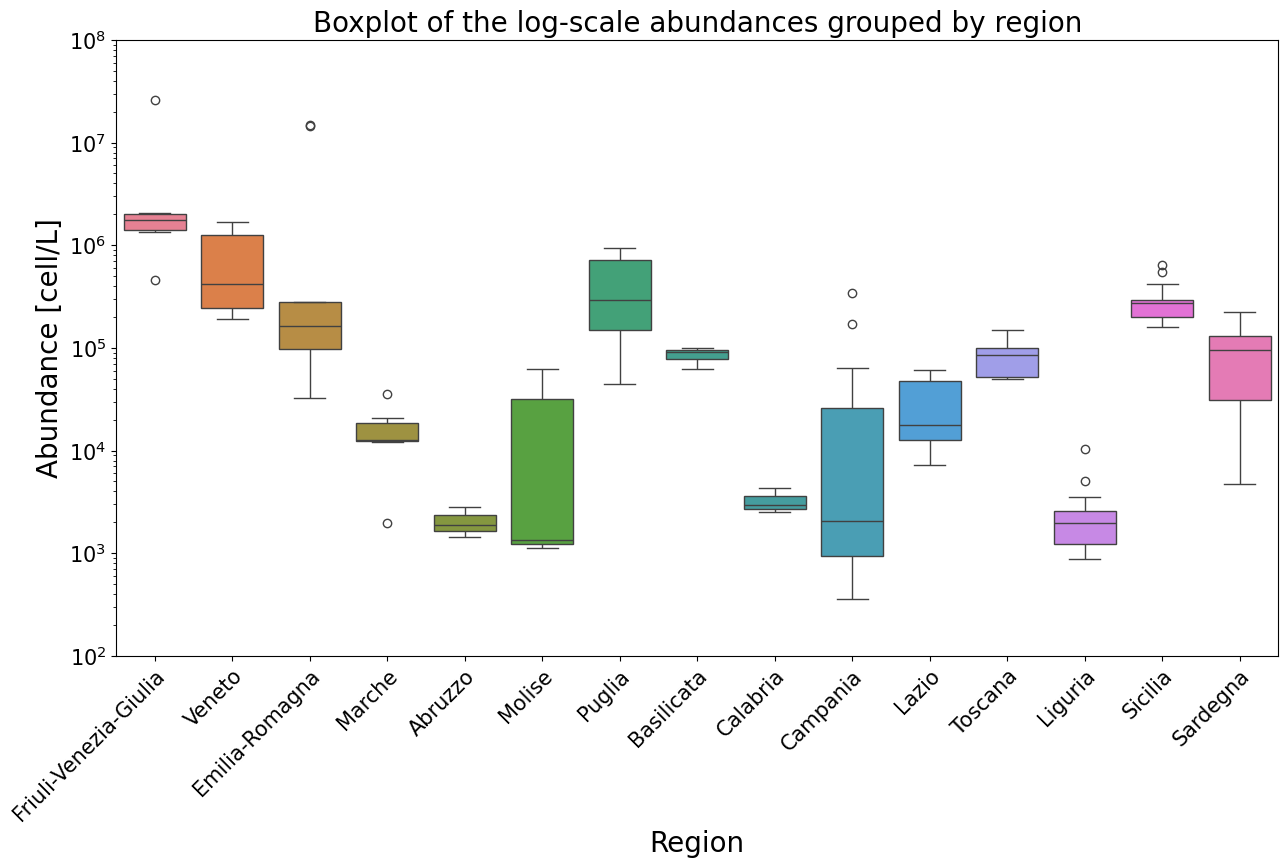

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
#ax.hlines(10**6, -0.5, 15, colors="k", linestyles="dashed")
sns.boxplot(
    df_abund_july.groupby(["Region", "id"], observed = True).sum("Num_cell_l").loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
ax.set_yscale("log")
plt.title("Boxplot of the log-scale abundances grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Abundance [cell/L]", fontsize = 20)
ax.set_ylim(10**2, 10**8)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_abund_by_region.png",bbox_inches='tight')

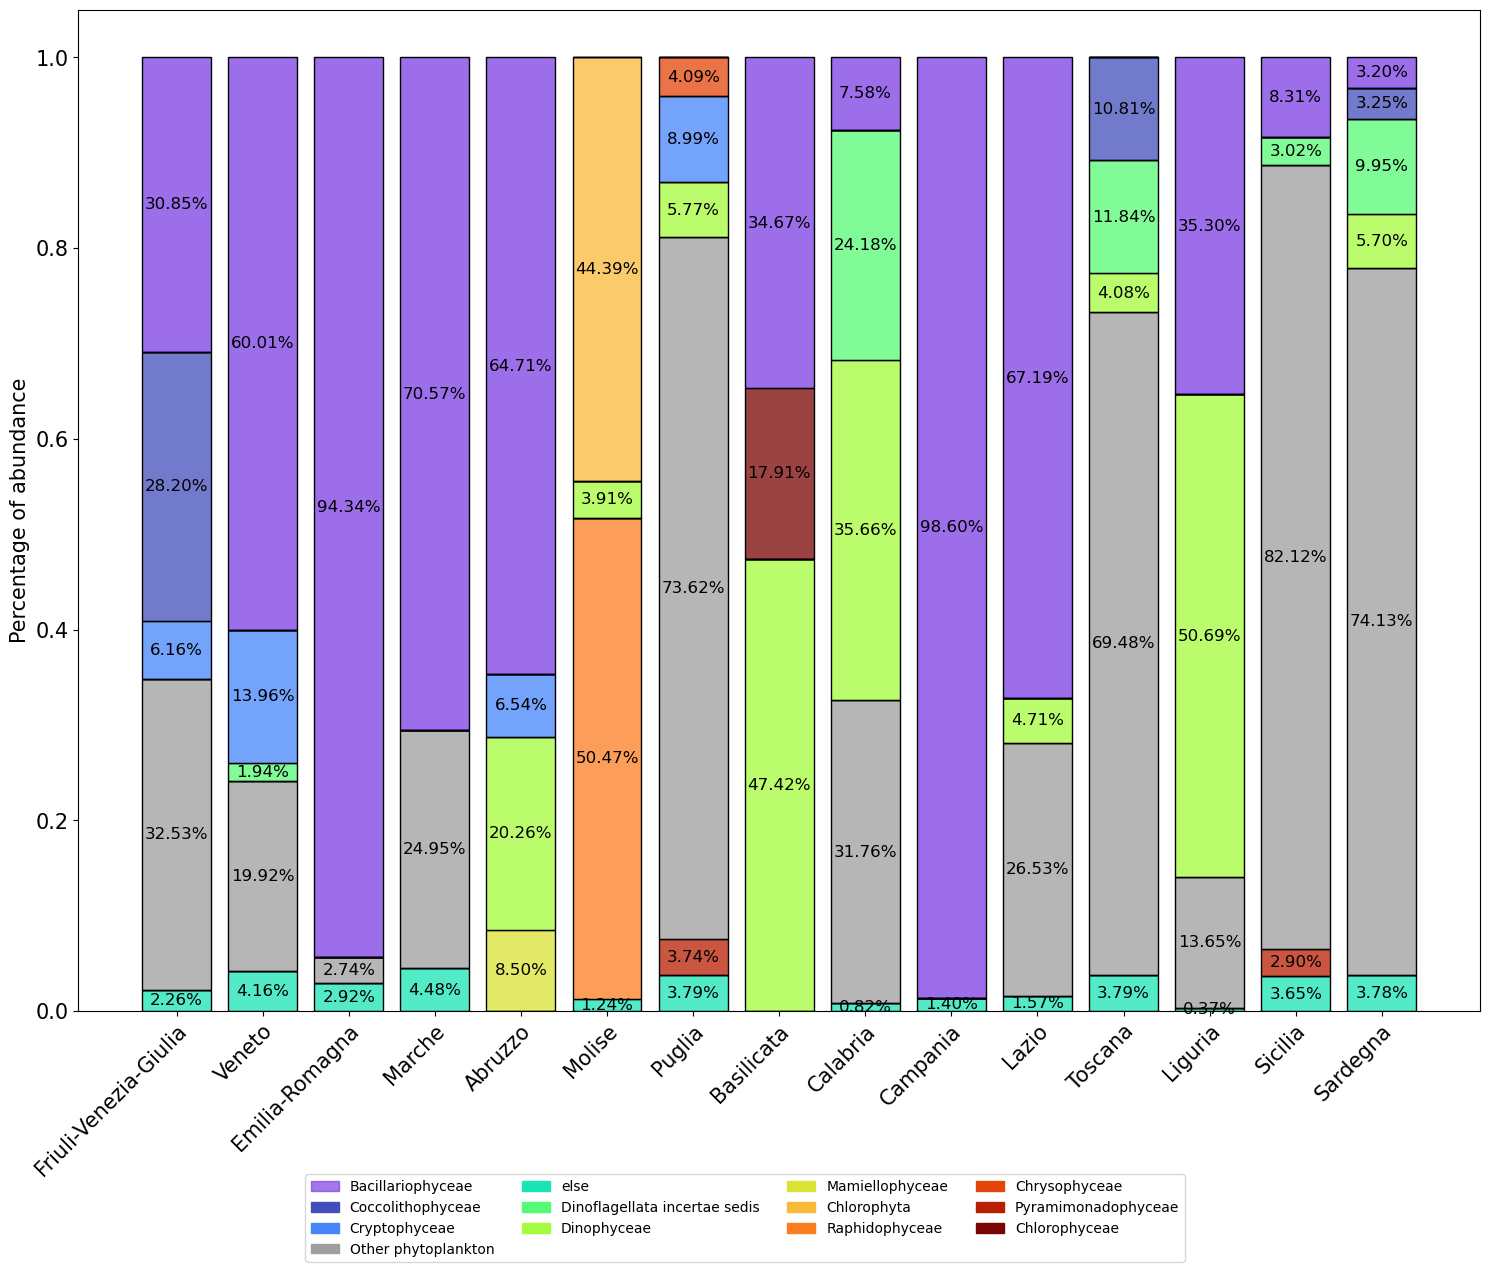

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12)) #5

threshold = 0.95
df_abund_by_class = pd.DataFrame({
    "Region" : [], 
    "Class" : [], 
    "Num_cell_l" : []
})
for (region, df_region) in df_abund_july.groupby("Region", observed=True):
    df = df_region.loc[:, ["Class", "Taxon", "Num_cell_l"]]
    df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]
    df = df[["Class", "Num_cell_l"]].groupby("Class").sum().sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    df.iloc[idx:,0] = "else"
    df = df.groupby("Class").sum(numeric_only = True).reset_index()
    df["Region"] = region
    df_abund_by_class = pd.concat([df_abund_by_class, df])

df_abund_by_class["Region"] = pd.Categorical(df_abund_by_class["Region"], ordered=True, categories=ordered_regions)
all_names = df_abund_by_class["Class"].unique()
num_colors = all_names.size
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(all_names, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Other phytoplankton"] = [0.62, 0.62, 0.62, 1]

sns.histplot(
    df_abund_by_class.pivot_table(
        index="Region", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x), axis=1).stack().reset_index().rename(columns={0: "Percentage"}),
    x='Region',
    hue='Class',
    weights='Percentage',
    multiple='stack',
    discrete = True,
    ax=ax,
    palette=color_dict,
    legend=False,
    shrink = 0.8  # Adjust the binwidth to widen the distance between bars
    )
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=12, color='black')

ax.set_xlabel("")
ax.set_ylabel("Percentage of abundance", size = 15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_ylim(0,1.05)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in all_names]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Class_contribution_bar.png", bbox_inches='tight')

In [52]:
description = "barplots of abundaces per transect with the the composition of the abundances, added common palette and divided by n samples, adjusted colors"
@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    df_regions = {}
    all_names = set()
    for (region, df_region) in phyto_abund_simplified.groupby("Region", observed = True):
    
        df_region = df_abund_july.query("Region == @region")
        df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]
        threshold = 0.95
        class_abund = pd.DataFrame({
        "Class" : [],
        "Num_cell_l" : [],
        "Cumsum_percent" : [],
        "Transect"  : []
        })
        for transect in df_region["Transect"].unique():
            df = df_region.query(f"Transect == '{transect}'")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
            df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
            idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
            df.iloc[idx:,0] = "else"
            df = df.groupby("Class").sum(numeric_only = True).reset_index()
            df["Transect"] = transect
            class_abund = pd.concat([class_abund, df])
        samples = df_region[["Transect", "id"]].drop_duplicates().groupby("Transect", observed  = True).count().rename(columns={"id" : "Num_cell_l"})
        class_abund.set_index(["Transect", "Class"], inplace = True)
        class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
        class_abund = class_abund.reset_index()
        class_abund["Transect"] = pd.Categorical(class_abund["Transect"])
        class_abund = class_abund.merge(class_abund.pivot_table(
                index="Transect", columns="Class", values="Num_cell_l"
            ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Transect", "Class"])
        all_names = all_names.union(class_abund["Class"].unique())
        df_regions[region] = class_abund
    
    
    #creating colormap
    if len(all_names) <= 10:
        cmap = plt.get_cmap("tab10")
    else:   
        cmap = plt.get_cmap("tab20")
    colors = cmap.colors[:len(all_names)]
    color_dict = {name : color for name, color in zip(all_names, colors)}
    
    
    for (region, class_abund) in df_regions.items():
        
        ## create figure
        fig, ax = plt.subplots(1,1, figsize=(15, 10)) 

        ## histplot 
        sns.histplot(class_abund.loc[:, ["Transect", "Class", "Num_cell_l"]], x="Transect", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
        ax.set_yscale("log")
        ax.set_xlabel("Transect", size = 15)
        ax.set_ylabel("Abundance [cell/L]", size = 15)
        handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
        ax.legend(handles=handles, loc='best', ncol=2)

        filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
        val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
        for p in filled_patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            values = val_percent.loc[height, "Percentage"]
            ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, y + height), ha='center', va='bottom')

        plt.tight_layout()
        plt.title(region, size = 20, loc="center")
        plt.savefig(f"{file_path}/{output_dir}/{region}_abund_composition.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/July_2017", "Abund_comp_transect")

# RICH

## July 2017 

(0.0, 80.0)

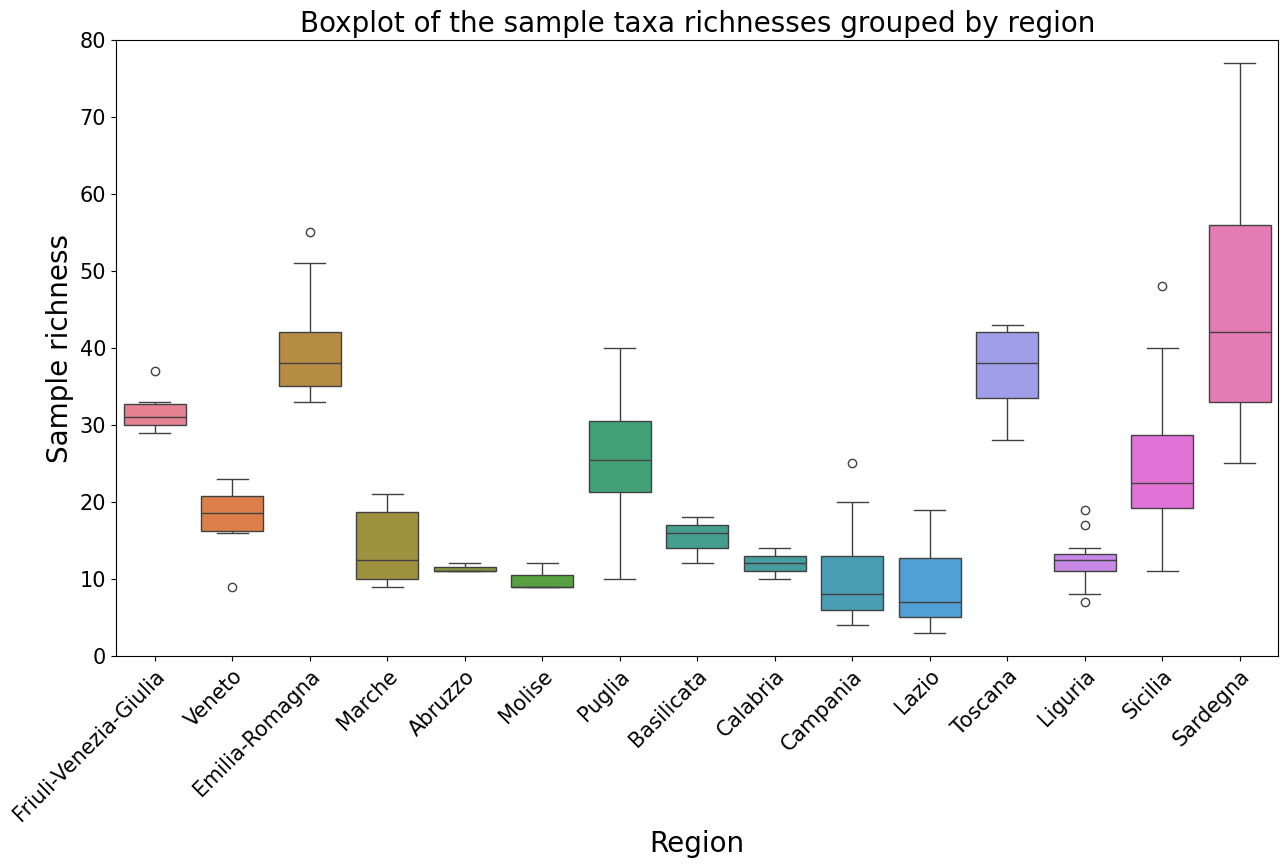

In [58]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
   df_abund_july.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    hue = "Region",
    ax = ax
)
plt.title("Boxplot of the sample taxa richnesses grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample richness", fontsize = 20)
ax.set_ylim(0, 80)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_richness_by_region.png",bbox_inches='tight')

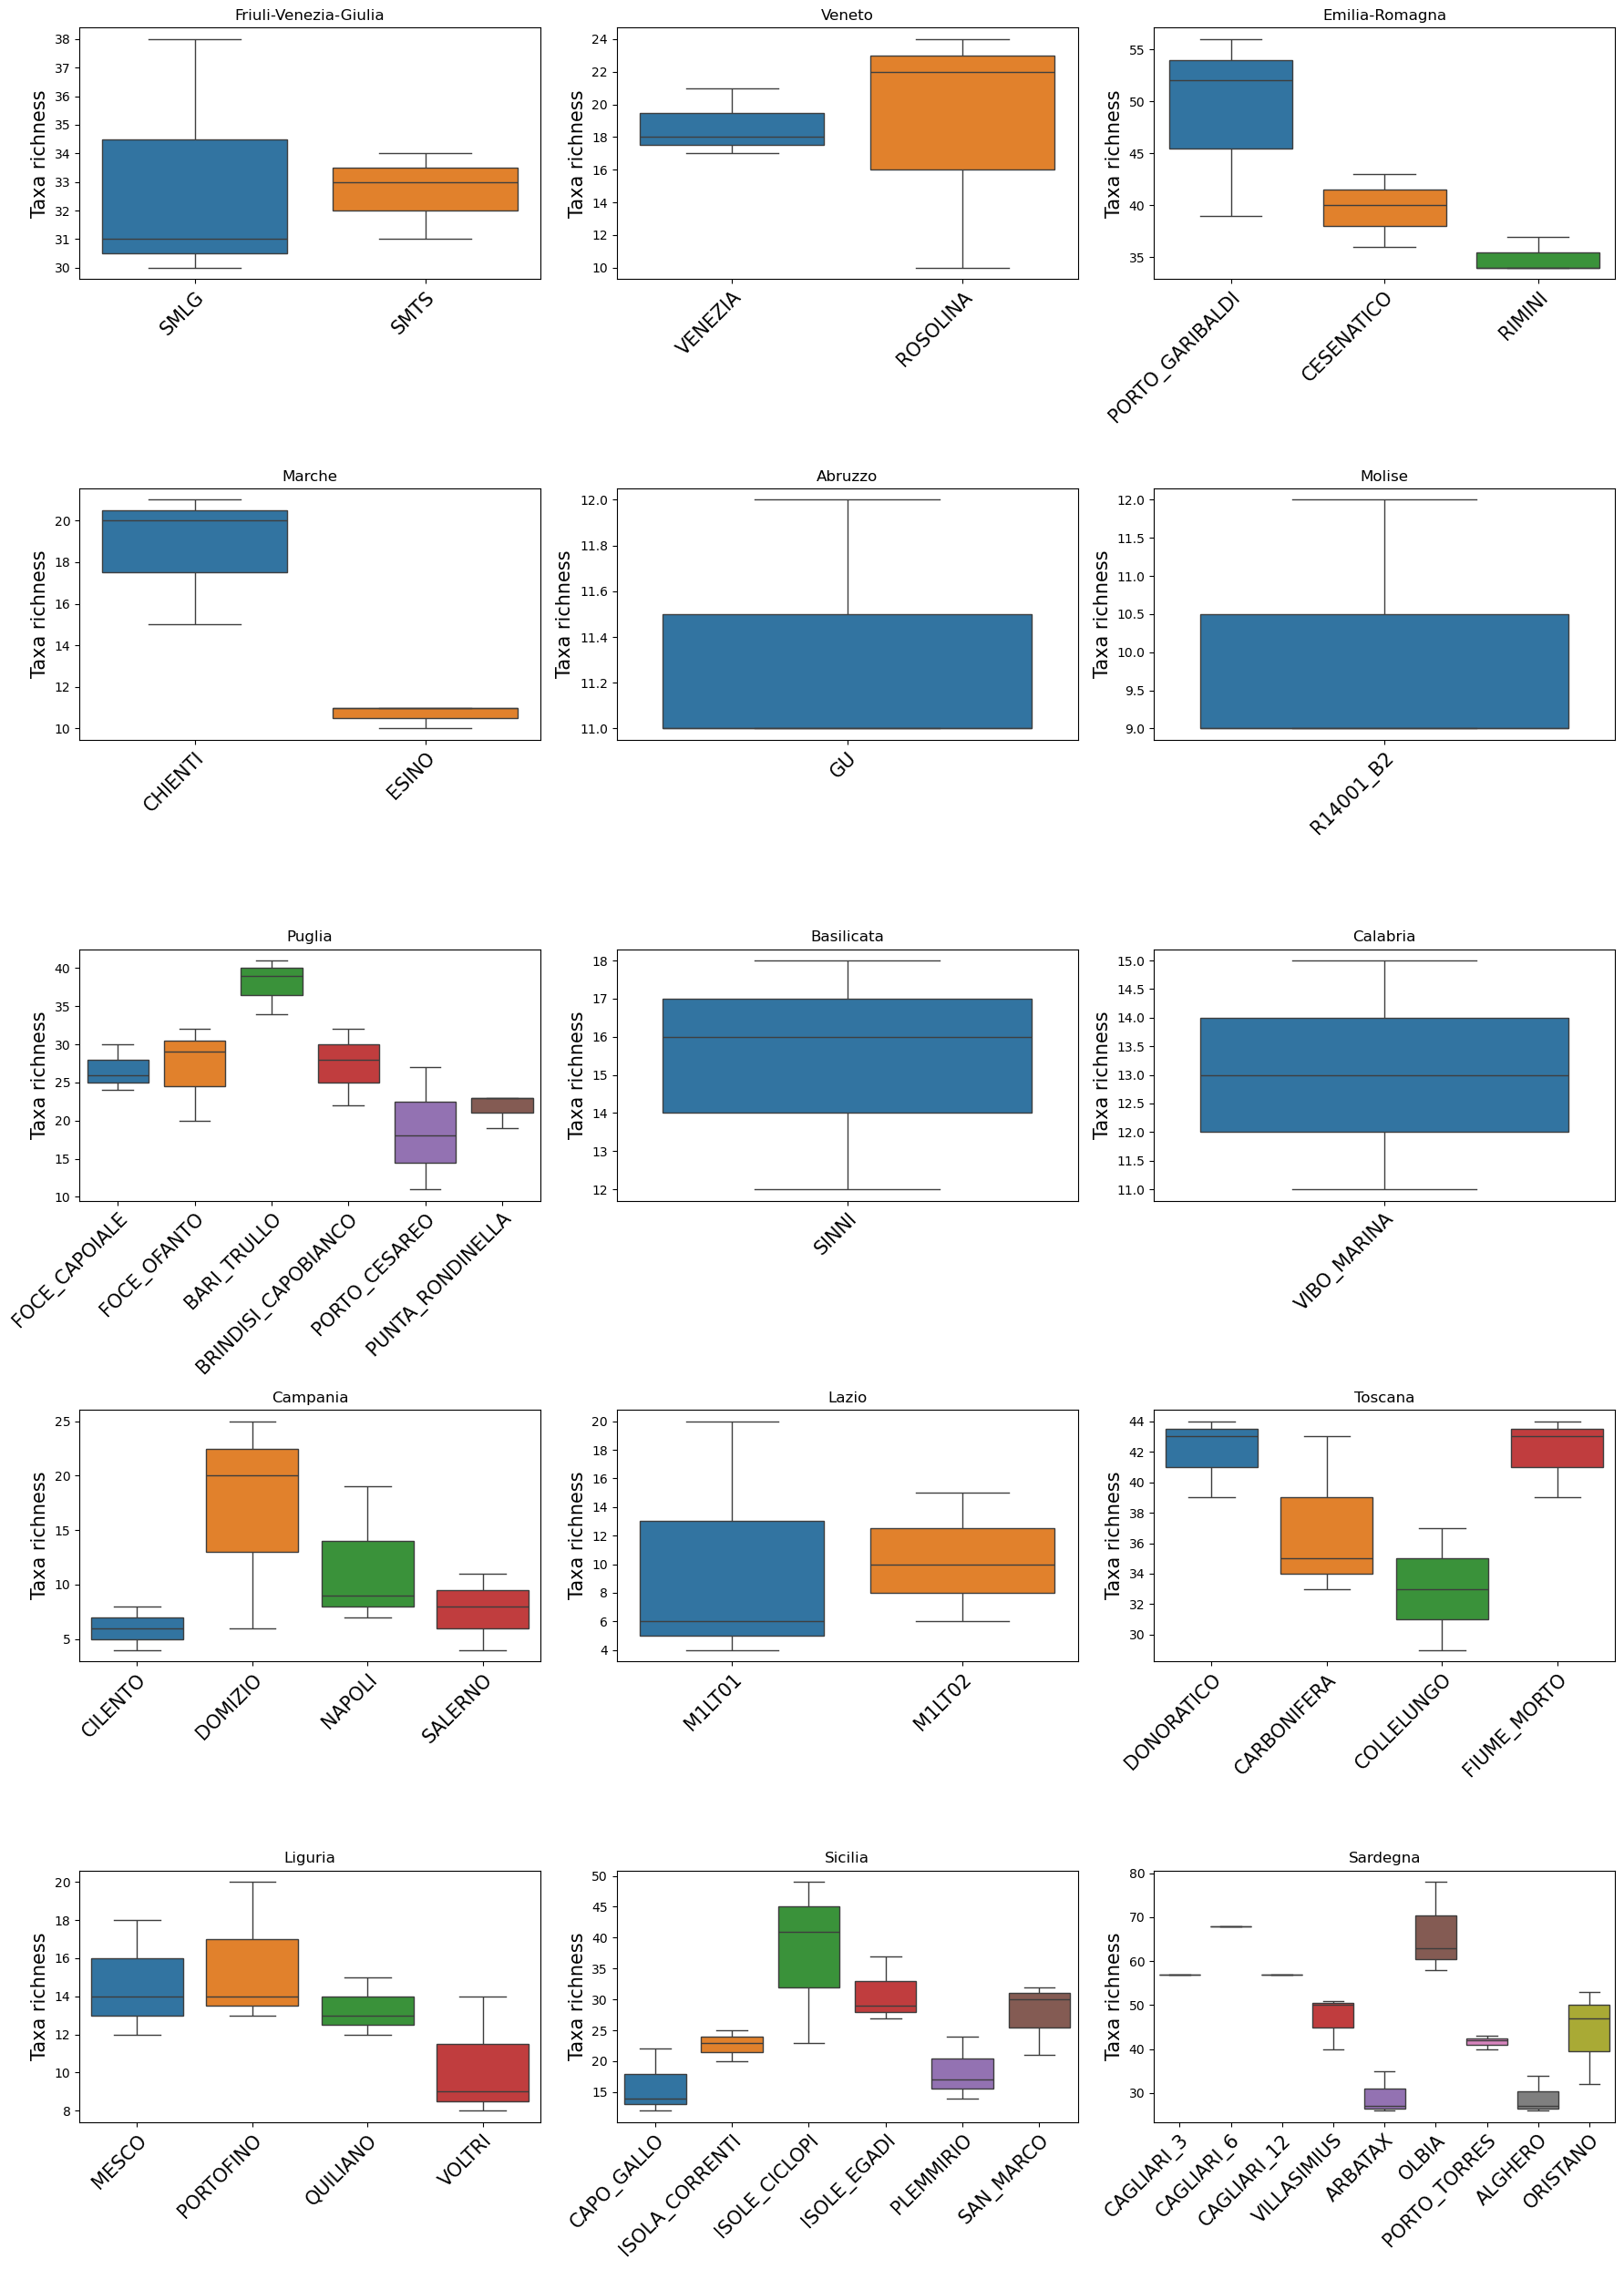

In [62]:
fig, axs = plt.subplots(5, 3, figsize=(18, 25))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, df_abund_july.groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby("id", observed = True).agg({"Taxon" : "count", "Transect" : "first"}).reset_index(),
        x = "Transect",
        y = "Taxon",
        hue = "Transect",
        ax = ax
    )
    #n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa richness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_by_season_per_region.png")

# EVENNESS

## July 2017

(-0.05, 1.05)

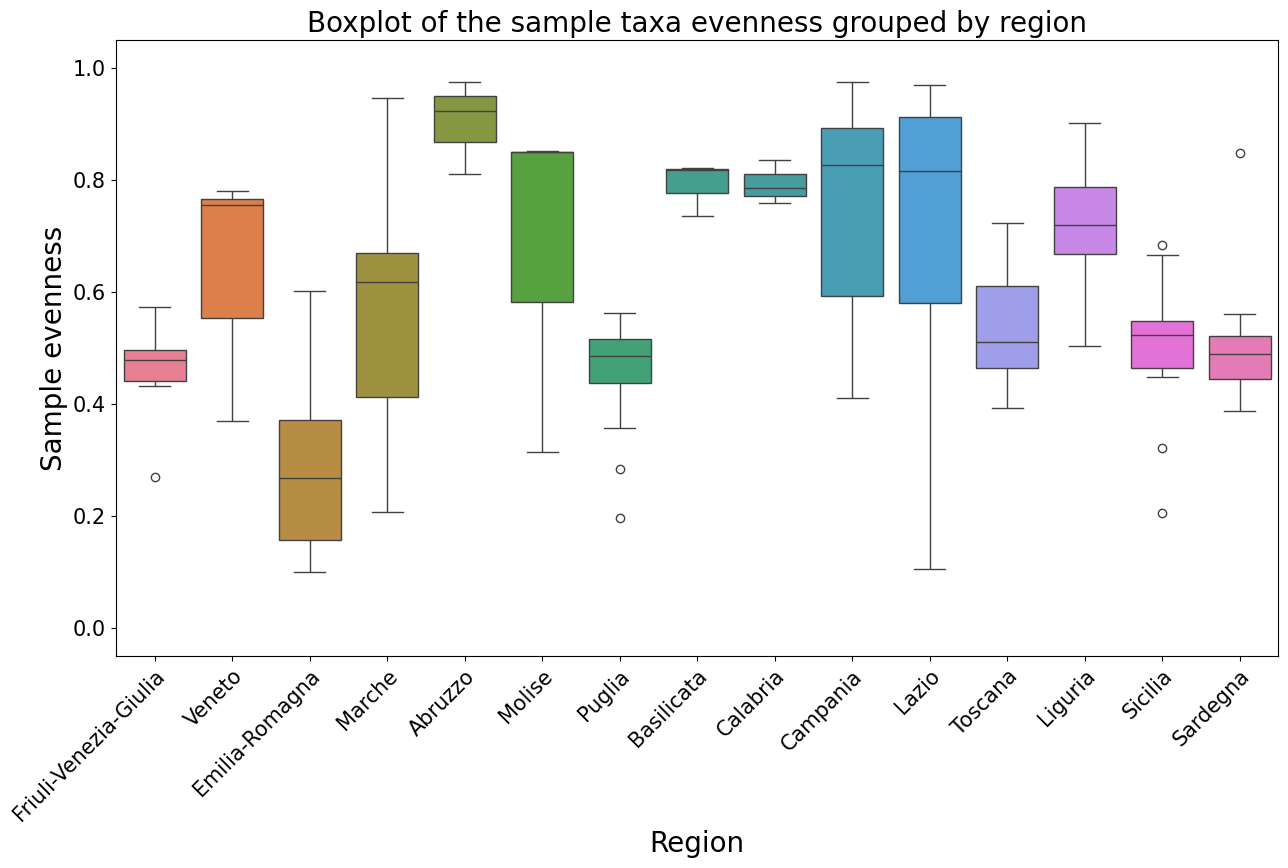

In [65]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    df_abund_july.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Num_cell_l"]].groupby(["Region", "id"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
plt.title("Boxplot of the sample taxa evenness grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample evenness", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_evenness_by_region.png",bbox_inches='tight')

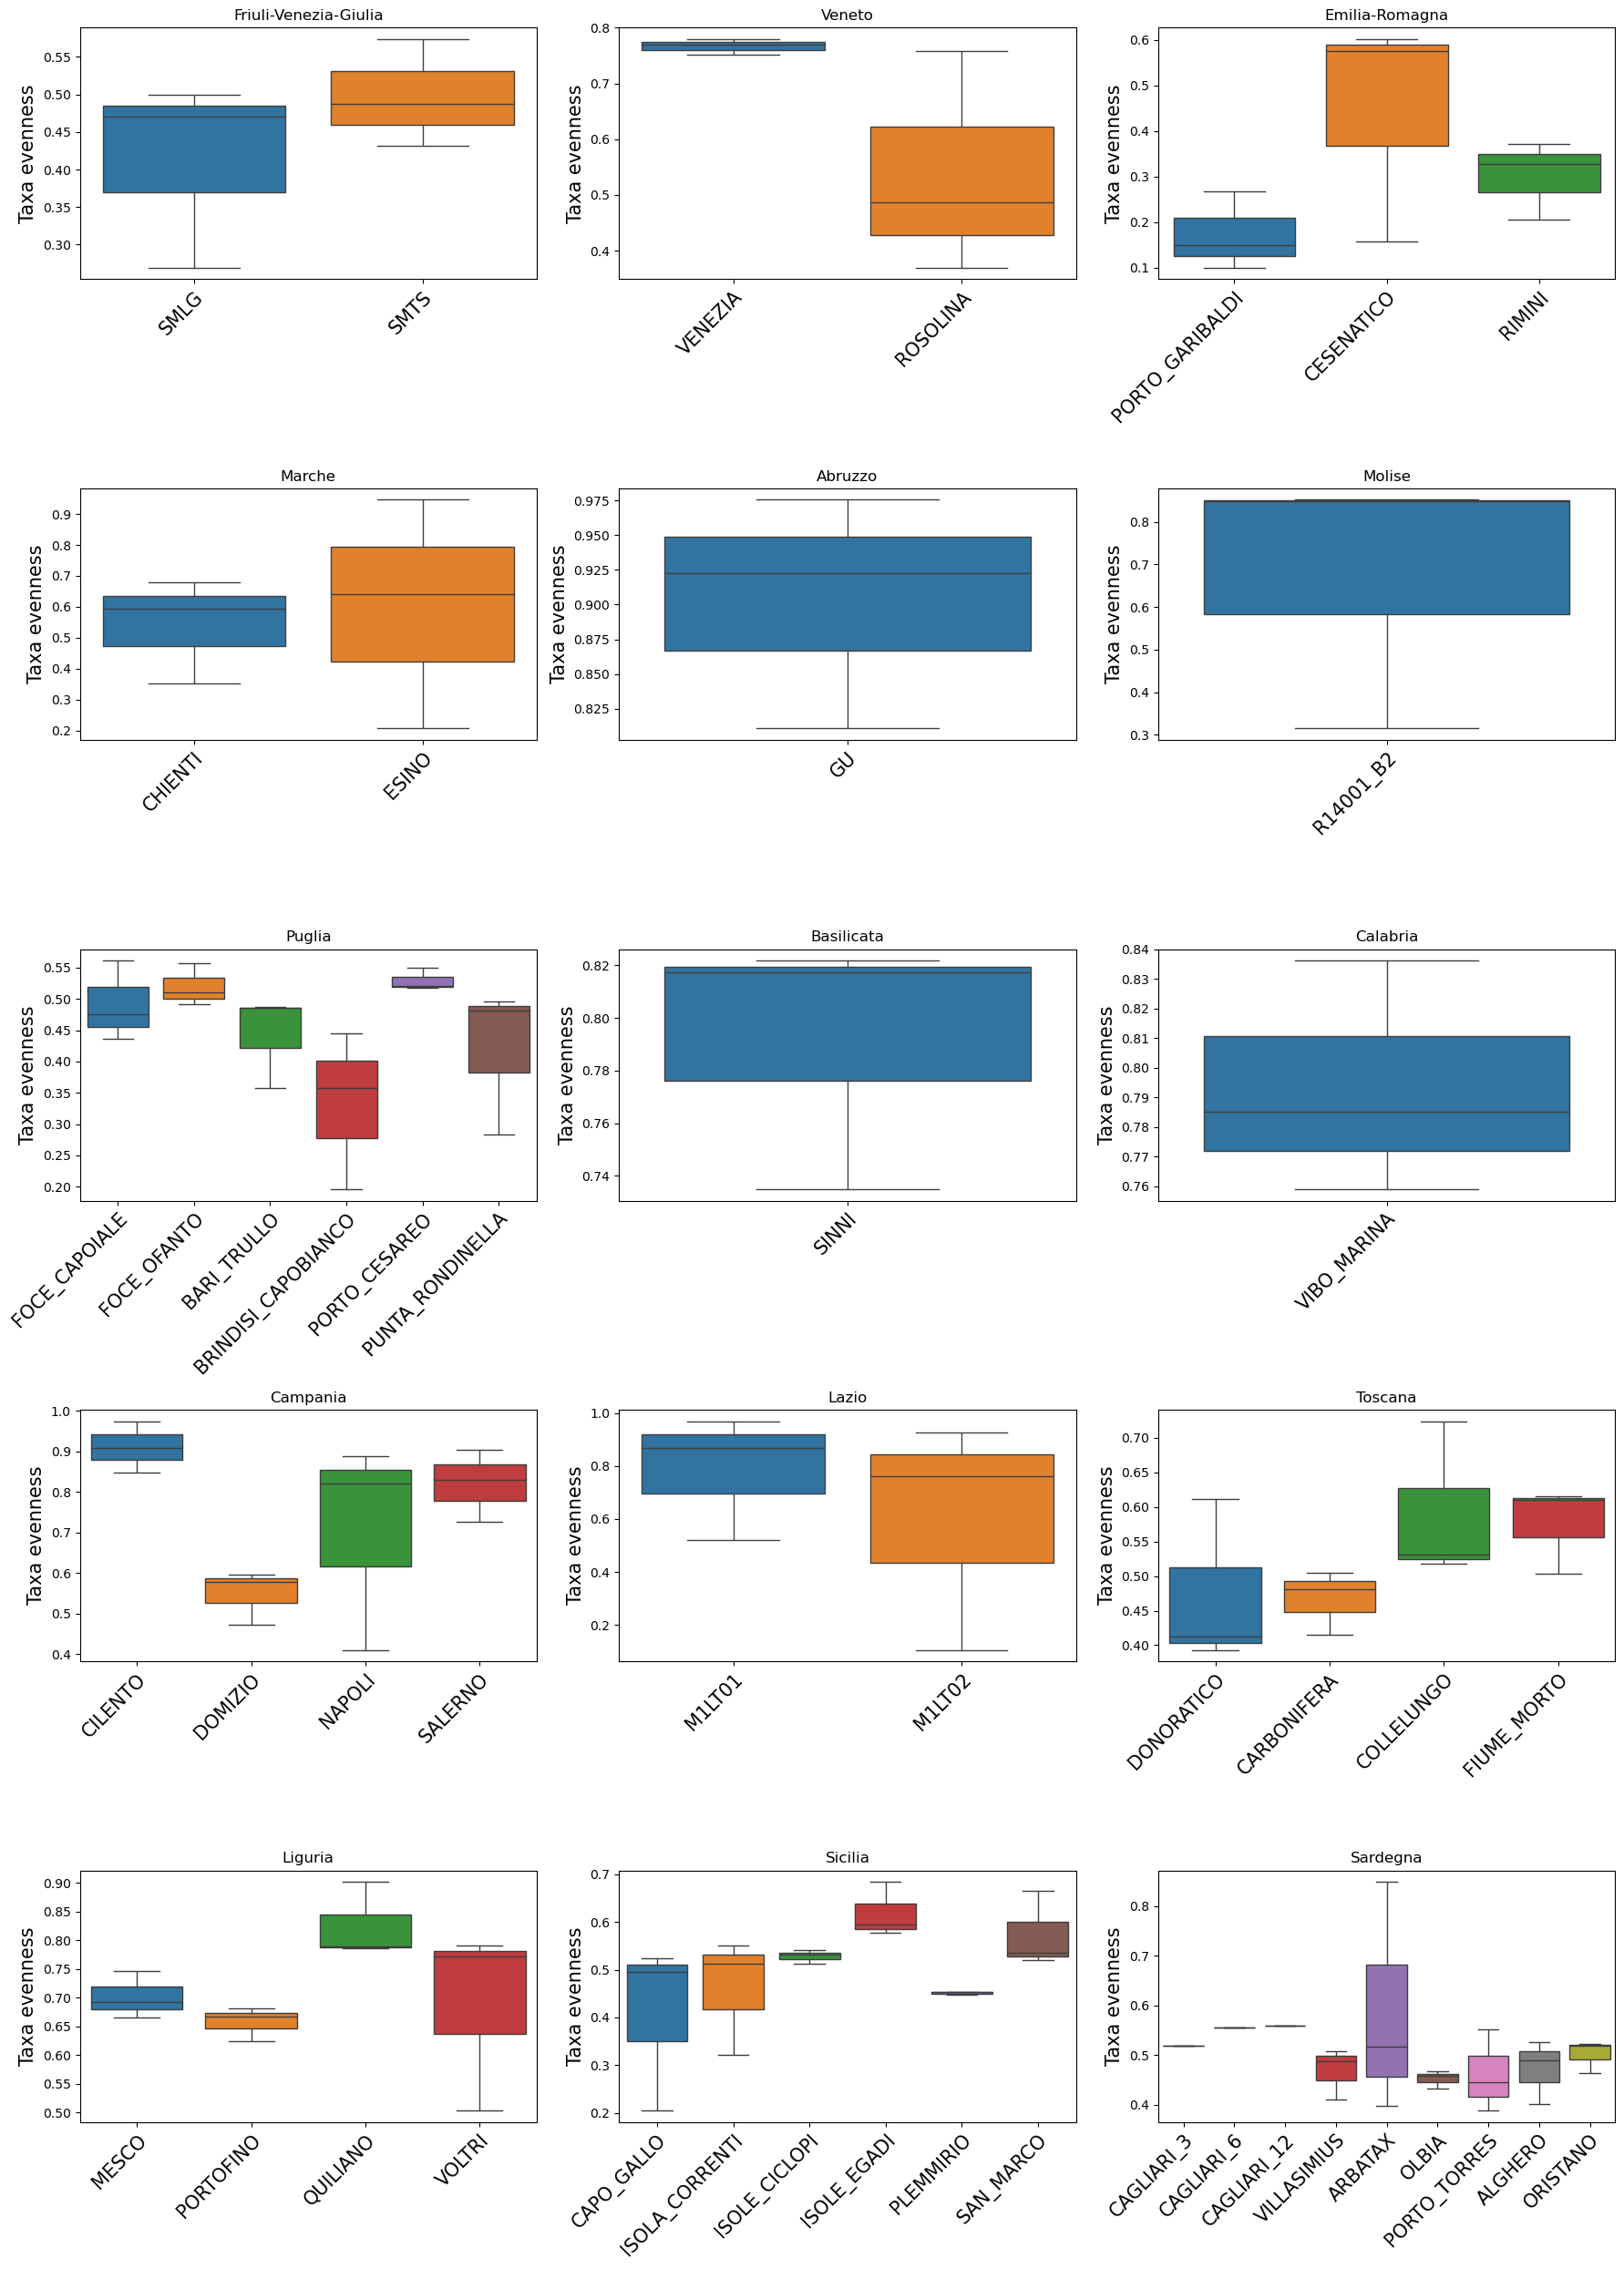

In [70]:
fig, axs = plt.subplots(5, 3, figsize=(18, 25))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, df_abund_july.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Transect", "Num_cell_l"]].groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby("id", observed = True).agg({"Num_cell_l" : Pielou_evenness, "Transect" : "first"}).reset_index(),
        x = "Transect",
        y = "Num_cell_l",
        hue = "Transect",
        ax = ax
    )
    #n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa evenness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_by_season_per_region.png")

# Composition

## July 2017

### taxa to keep

In [36]:
abund = df_abund_july.groupby("Taxon").mean(numeric_only = True).sort_values("Num_cell_l", ascending = False)

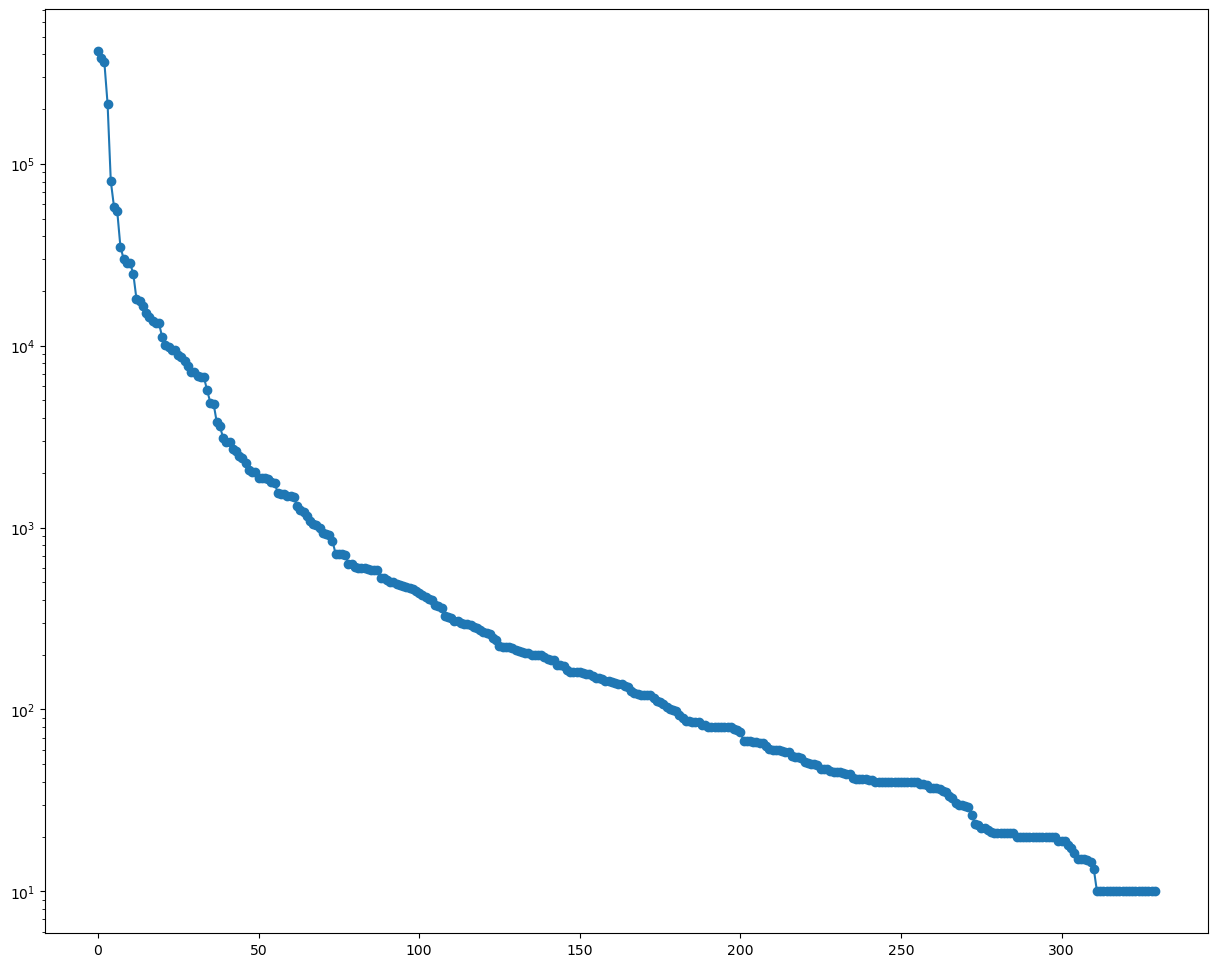

In [37]:
fgi, ax = plt.subplots(1, 1, figsize=(15, 12)) #5
ax.plot(abund["Num_cell_l"].to_numpy(), marker = "o")
ax.set_yscale("log")

In [44]:
taxa_to_keep = abund.reset_index().query("Taxon != 'Other phytoplankton'").query("Num_cell_l >= 1000")["Taxon"].to_numpy()

136 total samples

In [46]:
df_abund_july.query("Taxon in @taxa_to_keep")[["id"]].drop_duplicates().size

136

### df samples-taxa

In [127]:
taxa_to_keep = abund.reset_index().query("Taxon != 'Other phytoplankton'").query("Num_cell_l >= 1000")["Taxon"].to_numpy()
species_taxa = pd.pivot_table(df_abund_july.query("Taxon in @taxa_to_keep"), index="id", columns="Taxon", values="Num_cell_l", sort = True, fill_value=0)
indices = set(species_taxa.index)
ordered_indices = np.empty(len(indices), dtype="<U20")
i = 0
for id in ordered_id: 
    if id in indices: 
        ordered_indices[i] = id
        i += 1
species_taxa = species_taxa.loc[ordered_indices, :]

### jaccard

#### station-based

In [139]:
jaccard_score = pd.DataFrame(data = 1 - pairwise_distances(species_taxa.to_numpy() > 0, metric="jaccard"), index = species_taxa.index, columns=species_taxa.index)
index = phyto_abund_simplified[["Region", "id"]].drop_duplicates().set_index("id").loc[jaccard_score.index, "Region"].to_numpy()
jaccard_score.index = index
jaccard_score.columns = jaccard_score.index

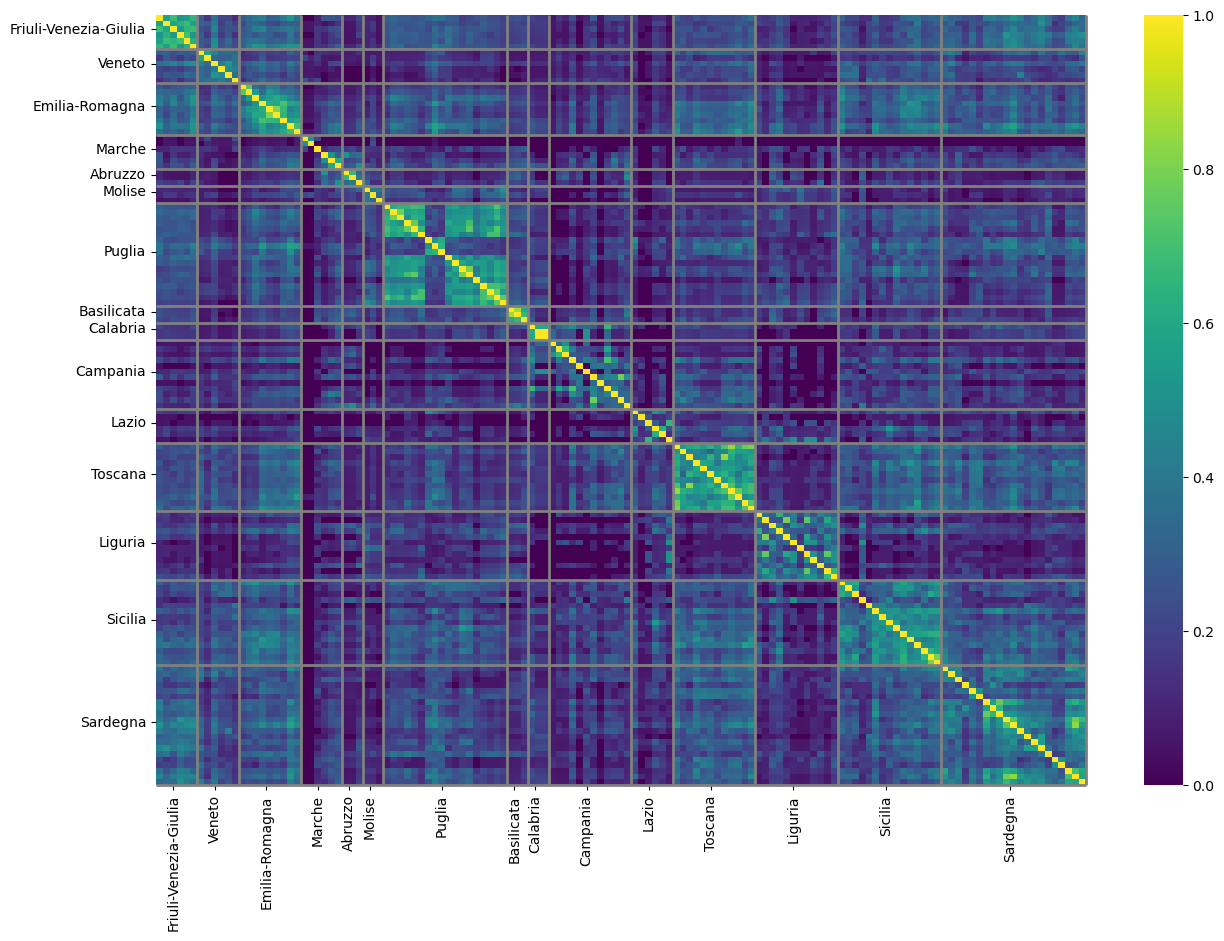

In [186]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sns.heatmap(jaccard_score, cmap="viridis", ax = ax)
ax.set_xticks(list(map(np.mean, [np.where(jaccard_score.index == region)[0] for region in jaccard_score.index.unique()])))
ax.set_xticklabels(labels = jaccard_score.index.unique());
ax.set_yticks(list(map(np.mean, [np.where(jaccard_score.index == region)[0] for region in jaccard_score.index.unique()])))
ax.set_yticklabels(labels = jaccard_score.index.unique());
line_coordinates = [np.where(jaccard_score.index == region)[0][-1] + 1 for region in jaccard_score.index.unique()]
ax.hlines(line_coordinates, xmin = 0, xmax = jaccard_score.index.size, colors = "gray", linewidth = 2, clip_on = False)
ax.vlines(line_coordinates, ymin = 0, ymax = jaccard_score.index.size, colors = "gray", linewidth = 2, clip_on = False)

### clustering

#### station_based

In [187]:
abund_hellinger = species_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
H_clusters = AgglomerativeClustering(n_clusters = 15, metric = "euclidean", linkage = "ward", compute_distances = True)


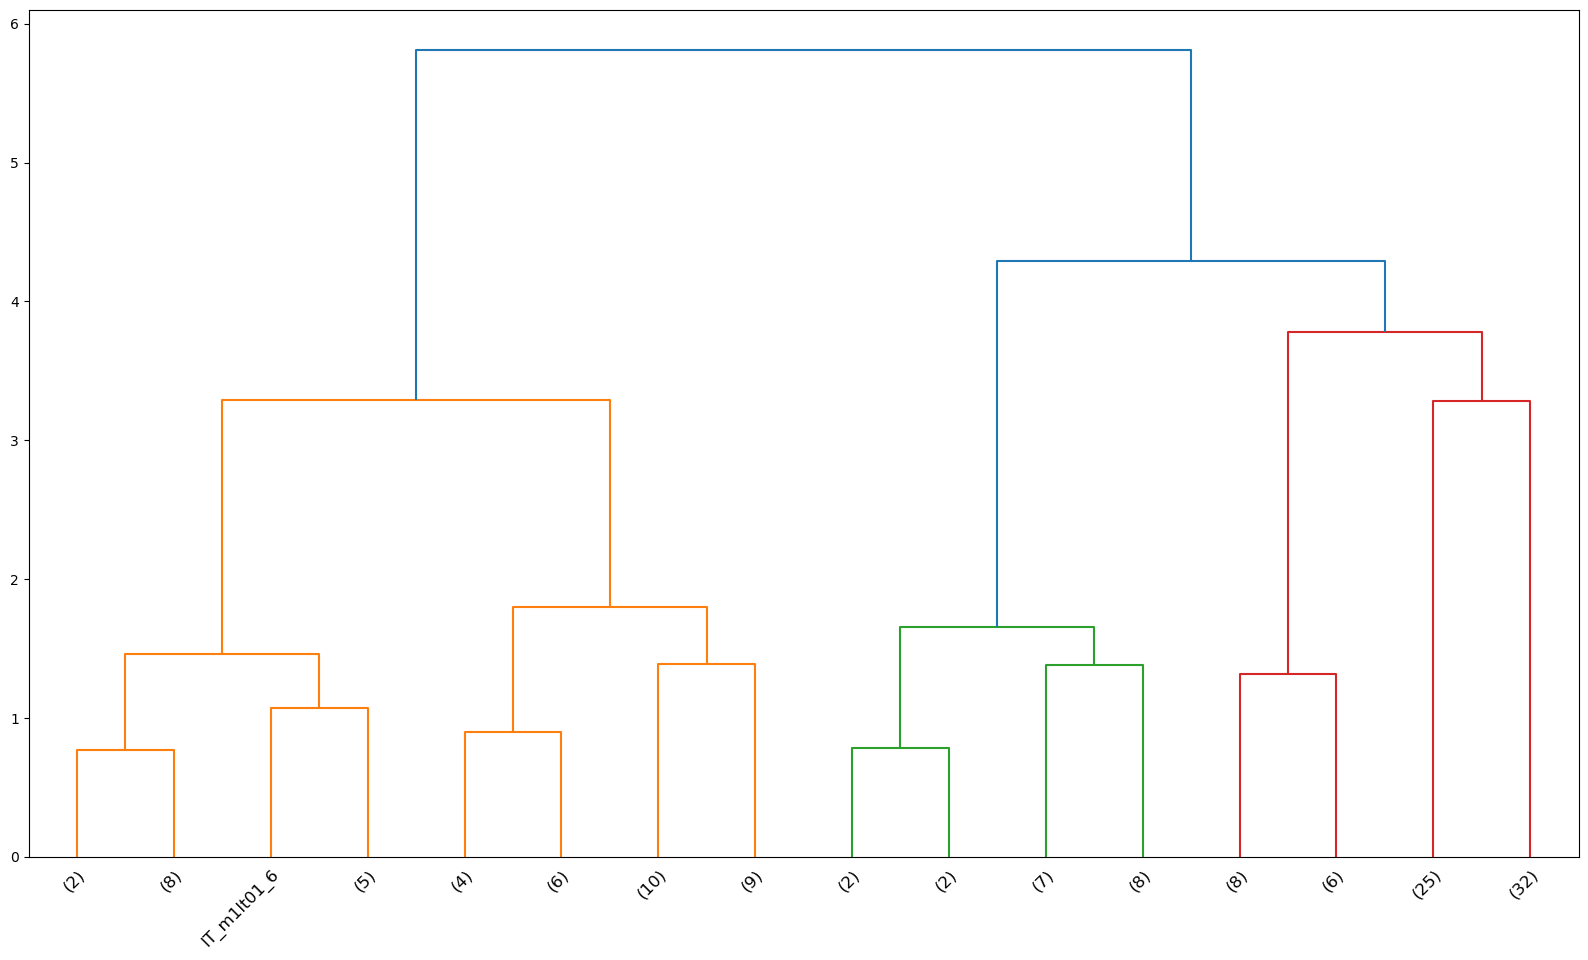

In [188]:
H_clusters = AgglomerativeClustering(n_clusters = 15, metric = "euclidean", linkage = "ward", compute_distances = True)
hellinger_clusers = H_clusters.fit(abund_hellinger.to_numpy())
fig, ax = plt.subplots(1,1, figsize=(20, 11))
R = plotting.plot_dendrogram(H_clusters, ax = ax, truncate_mode = "level", p = 3, labels = species_taxa.index, leaf_rotation = 45)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");

In [197]:
cluster_labels = phyto_abund_simplified[["id", "Longitude", "Latitude"]].drop_duplicates().set_index("id").loc[species_taxa.index]

In [199]:
cluster_labels["Label"] = H_clusters.labels_

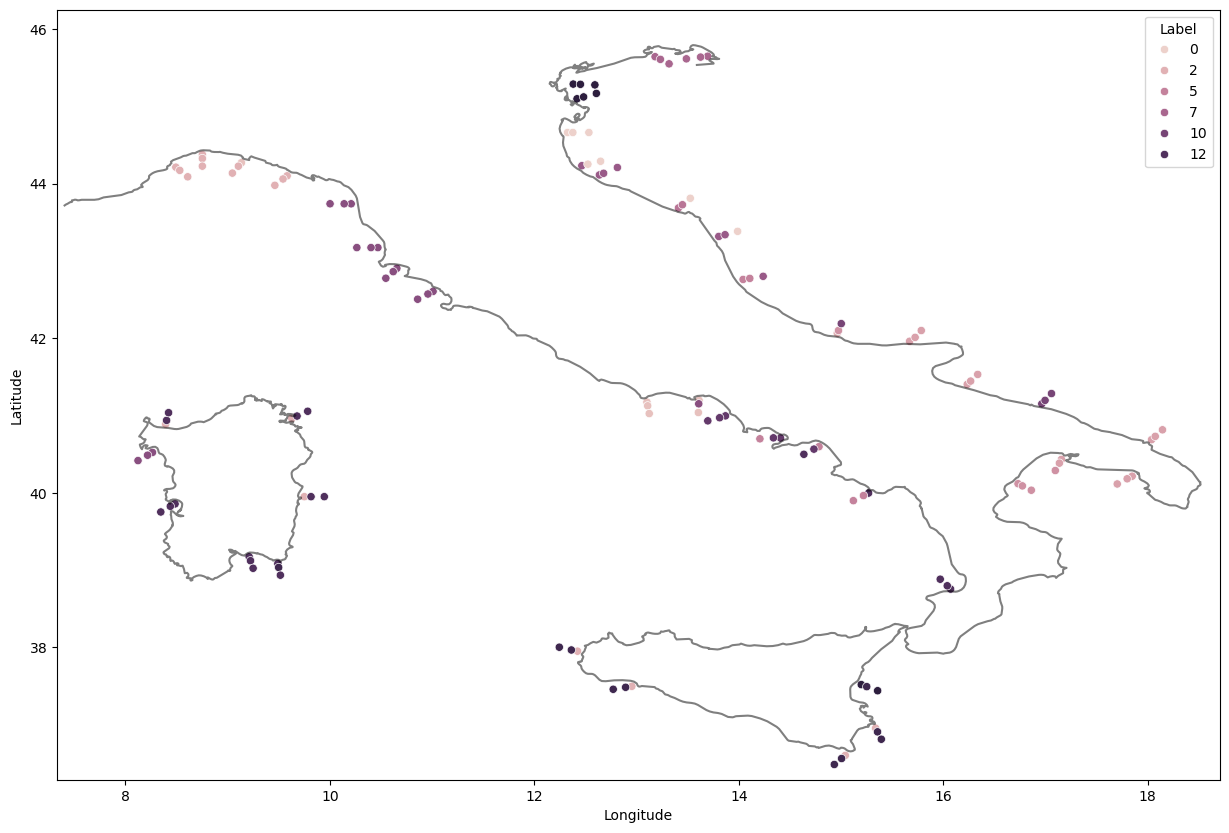

In [203]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
#colors = make_colors_from_labels(clustering.labels_)
#cm, bounds, norm = discrete_colormap(clustering.labels_)
plotting.plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.5)
sns.scatterplot(cluster_labels, x = "Longitude", y = "Latitude", hue = "Label")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#plt.colorbar(sc, cmap=cm, norm=norm,
#    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', label = "# of species")
plt.show()

#### species-based

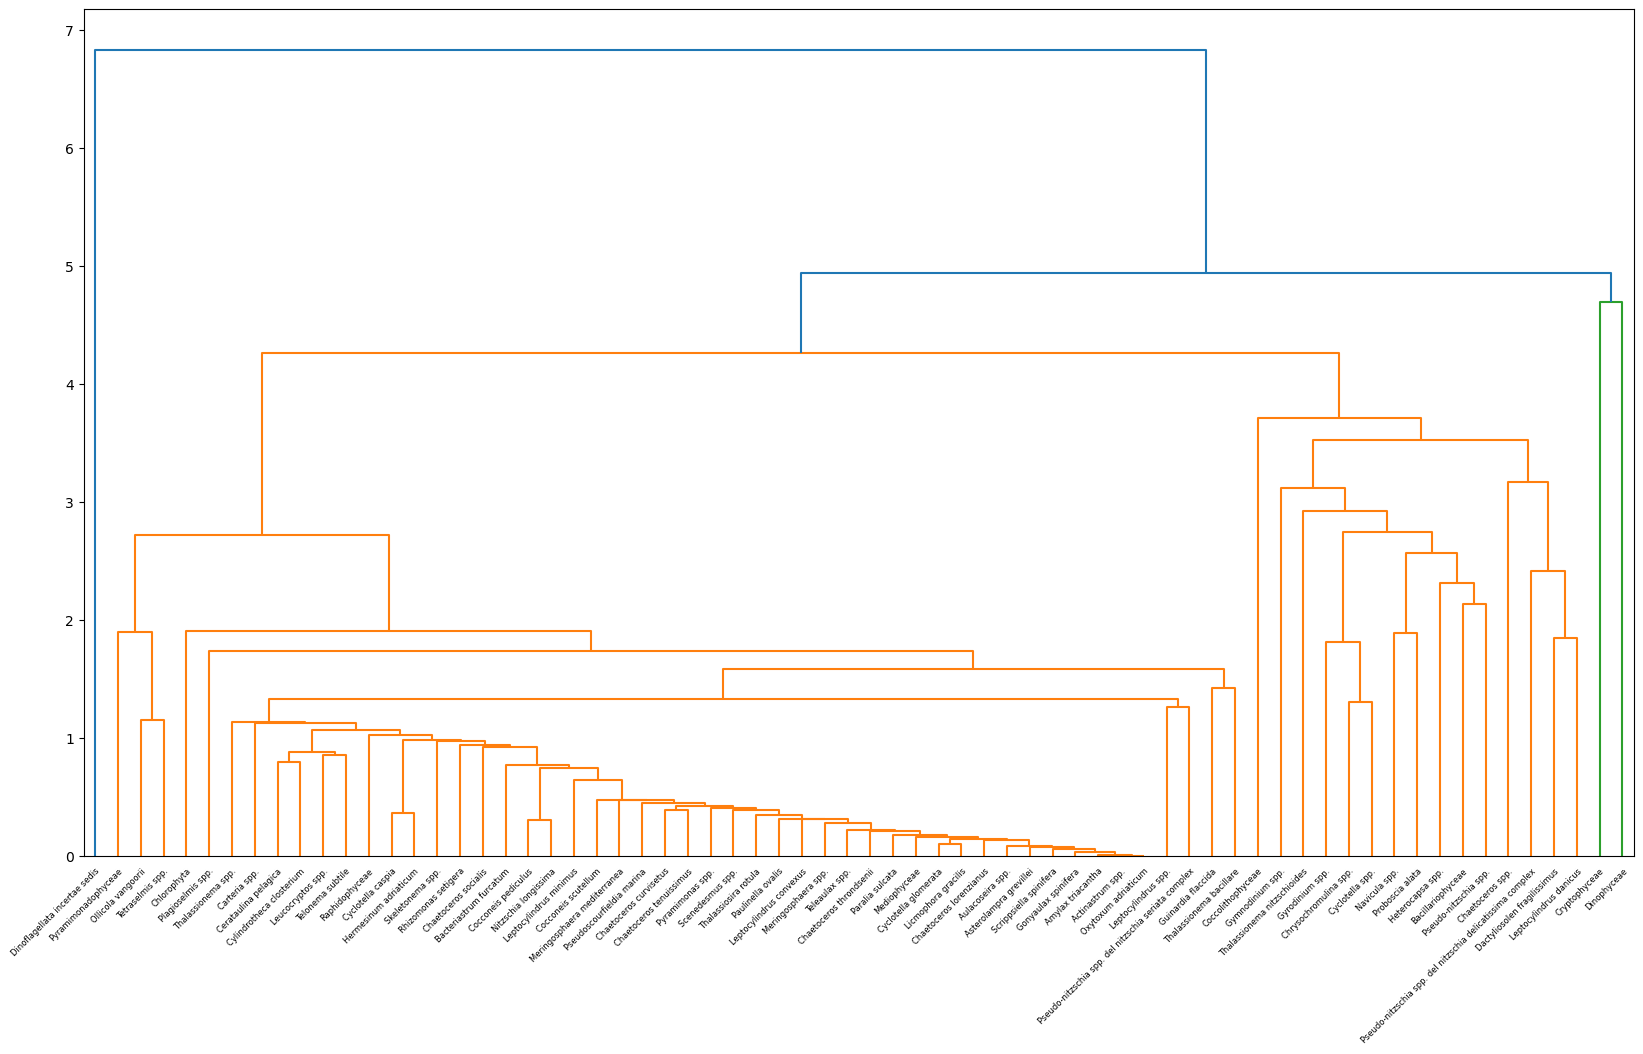

In [70]:
hellinger_clusers = H_clusters.fit(abund_hellinger.T.to_numpy())
fig, ax = plt.subplots(1,1, figsize=(20, 11))
R = plotting.plot_dendrogram(H_clusters, ax = ax, labels = species_taxa.columns, leaf_rotation = 45)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");